# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

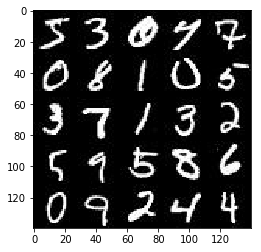

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

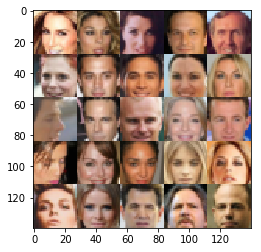

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


/Users/rahall4405/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, shape=[None, image_width, image_height, image_channels], name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='inputs_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2
        std_dev = 0.01
        # 28x28 input 
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=std_dev))
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=std_dev))
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7X7X128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=1, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=std_dev))
        bn3 = tf.layers.batch_normalization(x2, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 7X7X256
        x4 = tf.layers.conv2d(relu3, 512, 5, strides=1, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=std_dev))
        bn4 = tf.layers.batch_normalization(x2, training=True)
        relu4 = tf.maximum(alpha * bn4, bn4)
        # 7X7X512
        dimensions = relu4.get_shape().as_list()
        
        
      
        
        
        # Flatten it
        flat = tf.reshape(relu4, (-1, dimensions[1]*dimensions[2]*dimensions[3]))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*512)
        alpha=0.2
        std_dev = 0.01
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x256 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=std_dev))
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 now
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=std_dev))
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x128 now
        
        x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides=1, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=std_dev))
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        # 28x28x64
        # Output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=1, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=std_dev))
        
        
        out = tf.tanh(logits)
        
        return out

    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1-0.10)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height,image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z,image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    
    
    steps = 0
    print_every = 10
    show_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images*2
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr:learning_rate})

              

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z, input_real: batch_images})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, 50, input_z, image_channels, data_image_mode)       
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.3820... Generator Loss: 0.5113
Epoch 1/2... Discriminator Loss: 1.2386... Generator Loss: 0.6850
Epoch 1/2... Discriminator Loss: 1.4899... Generator Loss: 0.5335
Epoch 1/2... Discriminator Loss: 1.4983... Generator Loss: 0.6362
Epoch 1/2... Discriminator Loss: 1.3977... Generator Loss: 0.6559
Epoch 1/2... Discriminator Loss: 1.5669... Generator Loss: 0.6147
Epoch 1/2... Discriminator Loss: 1.6166... Generator Loss: 0.5933
Epoch 1/2... Discriminator Loss: 1.5480... Generator Loss: 0.6391
Epoch 1/2... Discriminator Loss: 1.4857... Generator Loss: 0.6457
Epoch 1/2... Discriminator Loss: 1.4637... Generator Loss: 0.7358


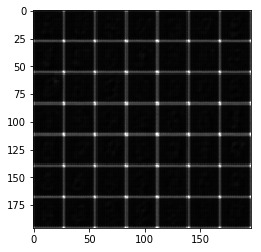

Epoch 1/2... Discriminator Loss: 1.3147... Generator Loss: 0.7253
Epoch 1/2... Discriminator Loss: 1.4996... Generator Loss: 0.8513
Epoch 1/2... Discriminator Loss: 1.4612... Generator Loss: 0.6748
Epoch 1/2... Discriminator Loss: 1.5042... Generator Loss: 0.6991
Epoch 1/2... Discriminator Loss: 1.4212... Generator Loss: 0.7861
Epoch 1/2... Discriminator Loss: 1.4680... Generator Loss: 0.7001
Epoch 1/2... Discriminator Loss: 1.4646... Generator Loss: 0.6733
Epoch 1/2... Discriminator Loss: 1.5059... Generator Loss: 0.7365
Epoch 1/2... Discriminator Loss: 1.4119... Generator Loss: 0.7089
Epoch 1/2... Discriminator Loss: 1.2854... Generator Loss: 0.8683


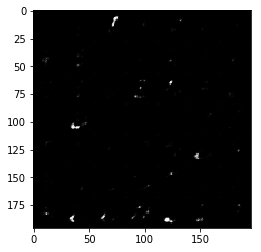

Epoch 1/2... Discriminator Loss: 1.4673... Generator Loss: 0.8572
Epoch 1/2... Discriminator Loss: 1.4100... Generator Loss: 0.7834
Epoch 1/2... Discriminator Loss: 1.5189... Generator Loss: 0.7149
Epoch 1/2... Discriminator Loss: 1.4801... Generator Loss: 0.7185
Epoch 1/2... Discriminator Loss: 1.3987... Generator Loss: 0.7609
Epoch 1/2... Discriminator Loss: 1.4321... Generator Loss: 0.6958
Epoch 1/2... Discriminator Loss: 1.5286... Generator Loss: 0.8297
Epoch 1/2... Discriminator Loss: 1.4208... Generator Loss: 0.7685
Epoch 1/2... Discriminator Loss: 1.3832... Generator Loss: 0.7317
Epoch 1/2... Discriminator Loss: 1.3293... Generator Loss: 0.8411


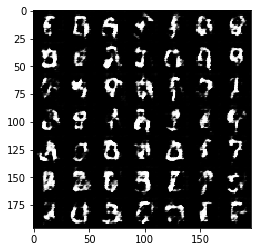

Epoch 1/2... Discriminator Loss: 1.3571... Generator Loss: 0.8337
Epoch 1/2... Discriminator Loss: 1.3455... Generator Loss: 0.9033
Epoch 1/2... Discriminator Loss: 1.3848... Generator Loss: 0.7964
Epoch 1/2... Discriminator Loss: 1.4706... Generator Loss: 0.6071
Epoch 1/2... Discriminator Loss: 1.3151... Generator Loss: 0.8444
Epoch 1/2... Discriminator Loss: 1.4979... Generator Loss: 0.6856
Epoch 1/2... Discriminator Loss: 1.4701... Generator Loss: 0.8177
Epoch 1/2... Discriminator Loss: 1.2784... Generator Loss: 0.8696
Epoch 1/2... Discriminator Loss: 1.3596... Generator Loss: 0.8529
Epoch 1/2... Discriminator Loss: 1.3089... Generator Loss: 0.8479


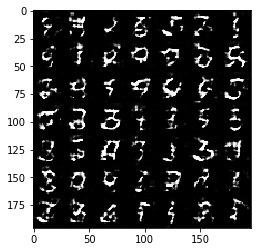

Epoch 1/2... Discriminator Loss: 1.2265... Generator Loss: 0.8913
Epoch 1/2... Discriminator Loss: 1.3735... Generator Loss: 0.7991
Epoch 1/2... Discriminator Loss: 1.3179... Generator Loss: 0.8841
Epoch 1/2... Discriminator Loss: 1.3576... Generator Loss: 0.7323
Epoch 1/2... Discriminator Loss: 1.3431... Generator Loss: 0.7619
Epoch 1/2... Discriminator Loss: 1.4445... Generator Loss: 0.8721
Epoch 1/2... Discriminator Loss: 1.3962... Generator Loss: 0.7257
Epoch 1/2... Discriminator Loss: 1.3467... Generator Loss: 0.7848
Epoch 1/2... Discriminator Loss: 1.3869... Generator Loss: 0.8024
Epoch 1/2... Discriminator Loss: 1.3605... Generator Loss: 0.7590


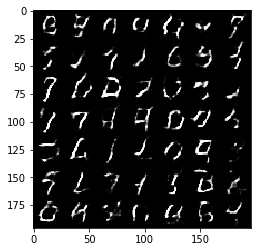

Epoch 1/2... Discriminator Loss: 1.4811... Generator Loss: 0.9206
Epoch 1/2... Discriminator Loss: 1.3722... Generator Loss: 0.7747
Epoch 1/2... Discriminator Loss: 1.3801... Generator Loss: 0.7438
Epoch 1/2... Discriminator Loss: 1.3350... Generator Loss: 0.7439
Epoch 1/2... Discriminator Loss: 1.4530... Generator Loss: 0.7703
Epoch 1/2... Discriminator Loss: 1.3688... Generator Loss: 0.7477
Epoch 1/2... Discriminator Loss: 1.4204... Generator Loss: 0.7273
Epoch 1/2... Discriminator Loss: 1.4112... Generator Loss: 0.7555
Epoch 1/2... Discriminator Loss: 1.3972... Generator Loss: 0.7307
Epoch 1/2... Discriminator Loss: 1.3899... Generator Loss: 0.7801


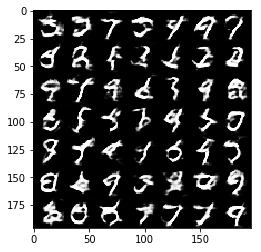

Epoch 1/2... Discriminator Loss: 1.3812... Generator Loss: 0.7972
Epoch 1/2... Discriminator Loss: 1.4621... Generator Loss: 0.7578
Epoch 1/2... Discriminator Loss: 1.3251... Generator Loss: 0.8669
Epoch 1/2... Discriminator Loss: 1.2786... Generator Loss: 0.9107
Epoch 1/2... Discriminator Loss: 1.4277... Generator Loss: 0.7143
Epoch 1/2... Discriminator Loss: 1.4008... Generator Loss: 0.7408
Epoch 1/2... Discriminator Loss: 1.4382... Generator Loss: 0.8020
Epoch 1/2... Discriminator Loss: 1.3966... Generator Loss: 0.7598
Epoch 1/2... Discriminator Loss: 1.3330... Generator Loss: 0.7829
Epoch 1/2... Discriminator Loss: 1.4088... Generator Loss: 0.7061


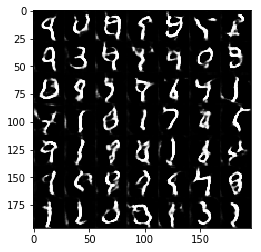

Epoch 1/2... Discriminator Loss: 1.3794... Generator Loss: 0.7923
Epoch 1/2... Discriminator Loss: 1.4012... Generator Loss: 0.8151
Epoch 1/2... Discriminator Loss: 1.3463... Generator Loss: 0.7390
Epoch 1/2... Discriminator Loss: 1.3181... Generator Loss: 0.7816
Epoch 1/2... Discriminator Loss: 1.3722... Generator Loss: 0.7385
Epoch 1/2... Discriminator Loss: 1.3011... Generator Loss: 0.8936
Epoch 1/2... Discriminator Loss: 1.3602... Generator Loss: 0.7559
Epoch 1/2... Discriminator Loss: 1.4116... Generator Loss: 0.7552
Epoch 1/2... Discriminator Loss: 1.4022... Generator Loss: 0.7306
Epoch 1/2... Discriminator Loss: 1.2985... Generator Loss: 0.8485


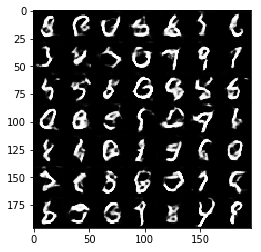

Epoch 1/2... Discriminator Loss: 1.3556... Generator Loss: 0.7595
Epoch 1/2... Discriminator Loss: 1.4322... Generator Loss: 0.6846
Epoch 1/2... Discriminator Loss: 1.4272... Generator Loss: 0.8882
Epoch 1/2... Discriminator Loss: 1.3583... Generator Loss: 0.7318
Epoch 1/2... Discriminator Loss: 1.3102... Generator Loss: 0.8568
Epoch 1/2... Discriminator Loss: 1.3918... Generator Loss: 0.6301
Epoch 1/2... Discriminator Loss: 1.4451... Generator Loss: 0.7467
Epoch 1/2... Discriminator Loss: 1.1751... Generator Loss: 0.9719
Epoch 1/2... Discriminator Loss: 1.4141... Generator Loss: 0.6690
Epoch 1/2... Discriminator Loss: 1.3514... Generator Loss: 0.8273


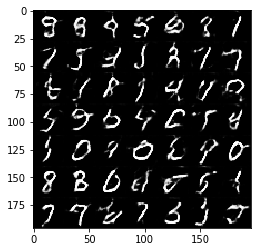

Epoch 1/2... Discriminator Loss: 1.3105... Generator Loss: 0.8544
Epoch 1/2... Discriminator Loss: 1.3157... Generator Loss: 0.8678
Epoch 1/2... Discriminator Loss: 1.3853... Generator Loss: 0.7834
Epoch 2/2... Discriminator Loss: 1.3593... Generator Loss: 0.7960
Epoch 2/2... Discriminator Loss: 1.3533... Generator Loss: 0.8728
Epoch 2/2... Discriminator Loss: 1.3499... Generator Loss: 0.8436
Epoch 2/2... Discriminator Loss: 1.3441... Generator Loss: 0.8259
Epoch 2/2... Discriminator Loss: 1.3234... Generator Loss: 0.8599
Epoch 2/2... Discriminator Loss: 1.3610... Generator Loss: 0.8175
Epoch 2/2... Discriminator Loss: 1.3341... Generator Loss: 0.9208


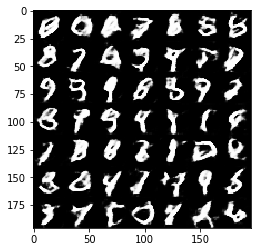

Epoch 2/2... Discriminator Loss: 1.3312... Generator Loss: 0.8420
Epoch 2/2... Discriminator Loss: 1.3083... Generator Loss: 0.7453
Epoch 2/2... Discriminator Loss: 1.2688... Generator Loss: 0.9021
Epoch 2/2... Discriminator Loss: 1.4276... Generator Loss: 0.7230
Epoch 2/2... Discriminator Loss: 1.3801... Generator Loss: 1.1041
Epoch 2/2... Discriminator Loss: 1.3668... Generator Loss: 0.8092
Epoch 2/2... Discriminator Loss: 1.3774... Generator Loss: 0.8266
Epoch 2/2... Discriminator Loss: 1.4170... Generator Loss: 0.7948
Epoch 2/2... Discriminator Loss: 1.3435... Generator Loss: 0.8167
Epoch 2/2... Discriminator Loss: 1.3659... Generator Loss: 0.8319


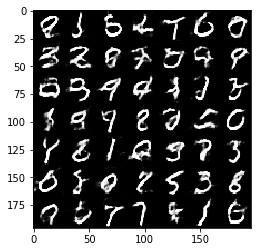

Epoch 2/2... Discriminator Loss: 1.1967... Generator Loss: 0.9111
Epoch 2/2... Discriminator Loss: 1.2929... Generator Loss: 0.8732
Epoch 2/2... Discriminator Loss: 1.3206... Generator Loss: 0.8711
Epoch 2/2... Discriminator Loss: 1.3775... Generator Loss: 0.7688
Epoch 2/2... Discriminator Loss: 1.3362... Generator Loss: 0.7840
Epoch 2/2... Discriminator Loss: 1.4280... Generator Loss: 0.8756
Epoch 2/2... Discriminator Loss: 1.2655... Generator Loss: 0.9634
Epoch 2/2... Discriminator Loss: 1.3623... Generator Loss: 0.8038
Epoch 2/2... Discriminator Loss: 1.3351... Generator Loss: 0.9223
Epoch 2/2... Discriminator Loss: 1.4137... Generator Loss: 0.7230


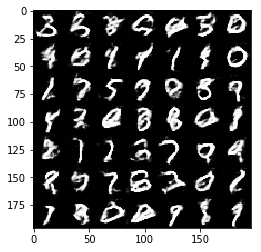

Epoch 2/2... Discriminator Loss: 1.3177... Generator Loss: 0.8647
Epoch 2/2... Discriminator Loss: 1.3742... Generator Loss: 0.8020
Epoch 2/2... Discriminator Loss: 1.3265... Generator Loss: 0.8193
Epoch 2/2... Discriminator Loss: 1.2918... Generator Loss: 0.9222
Epoch 2/2... Discriminator Loss: 1.3967... Generator Loss: 0.7647
Epoch 2/2... Discriminator Loss: 1.3401... Generator Loss: 0.7667
Epoch 2/2... Discriminator Loss: 1.3517... Generator Loss: 0.7862
Epoch 2/2... Discriminator Loss: 1.4351... Generator Loss: 0.6357
Epoch 2/2... Discriminator Loss: 1.2760... Generator Loss: 0.7809
Epoch 2/2... Discriminator Loss: 1.3896... Generator Loss: 0.7979


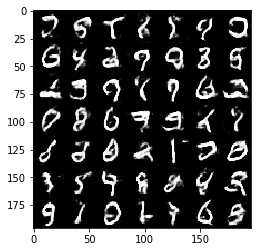

Epoch 2/2... Discriminator Loss: 1.3911... Generator Loss: 0.7704
Epoch 2/2... Discriminator Loss: 1.4655... Generator Loss: 0.7443
Epoch 2/2... Discriminator Loss: 1.3977... Generator Loss: 0.7592
Epoch 2/2... Discriminator Loss: 1.3595... Generator Loss: 0.8614
Epoch 2/2... Discriminator Loss: 1.3607... Generator Loss: 0.7751
Epoch 2/2... Discriminator Loss: 1.3381... Generator Loss: 0.8564
Epoch 2/2... Discriminator Loss: 1.2874... Generator Loss: 0.8576
Epoch 2/2... Discriminator Loss: 1.3700... Generator Loss: 0.8553
Epoch 2/2... Discriminator Loss: 1.3499... Generator Loss: 0.8741
Epoch 2/2... Discriminator Loss: 1.2958... Generator Loss: 0.8098


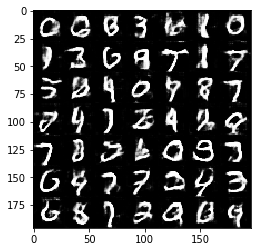

Epoch 2/2... Discriminator Loss: 1.2767... Generator Loss: 0.8745
Epoch 2/2... Discriminator Loss: 1.3440... Generator Loss: 0.7492
Epoch 2/2... Discriminator Loss: 1.4193... Generator Loss: 0.7416
Epoch 2/2... Discriminator Loss: 1.3124... Generator Loss: 0.8650
Epoch 2/2... Discriminator Loss: 1.3128... Generator Loss: 0.8041
Epoch 2/2... Discriminator Loss: 1.4043... Generator Loss: 0.7757
Epoch 2/2... Discriminator Loss: 1.3750... Generator Loss: 0.7441
Epoch 2/2... Discriminator Loss: 1.4257... Generator Loss: 0.7446
Epoch 2/2... Discriminator Loss: 1.3918... Generator Loss: 0.7670
Epoch 2/2... Discriminator Loss: 1.3384... Generator Loss: 0.7720


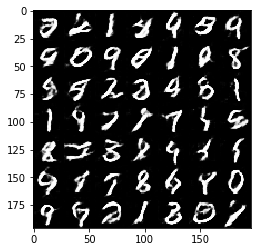

Epoch 2/2... Discriminator Loss: 1.3465... Generator Loss: 0.8156
Epoch 2/2... Discriminator Loss: 1.4072... Generator Loss: 0.8420
Epoch 2/2... Discriminator Loss: 1.3270... Generator Loss: 0.8025
Epoch 2/2... Discriminator Loss: 1.3647... Generator Loss: 0.8216
Epoch 2/2... Discriminator Loss: 1.2704... Generator Loss: 0.8825
Epoch 2/2... Discriminator Loss: 1.2579... Generator Loss: 0.8684
Epoch 2/2... Discriminator Loss: 1.4433... Generator Loss: 0.7634
Epoch 2/2... Discriminator Loss: 1.3677... Generator Loss: 0.8008
Epoch 2/2... Discriminator Loss: 1.3541... Generator Loss: 0.7948
Epoch 2/2... Discriminator Loss: 1.3526... Generator Loss: 0.8499


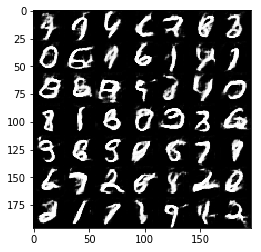

Epoch 2/2... Discriminator Loss: 1.4019... Generator Loss: 0.7003
Epoch 2/2... Discriminator Loss: 1.3489... Generator Loss: 0.7966
Epoch 2/2... Discriminator Loss: 1.3817... Generator Loss: 0.8823
Epoch 2/2... Discriminator Loss: 1.4309... Generator Loss: 0.7992
Epoch 2/2... Discriminator Loss: 1.3770... Generator Loss: 0.7425
Epoch 2/2... Discriminator Loss: 1.3295... Generator Loss: 0.8301
Epoch 2/2... Discriminator Loss: 1.3300... Generator Loss: 0.7889
Epoch 2/2... Discriminator Loss: 1.3829... Generator Loss: 0.7505
Epoch 2/2... Discriminator Loss: 1.3972... Generator Loss: 0.7339
Epoch 2/2... Discriminator Loss: 1.3722... Generator Loss: 0.7378


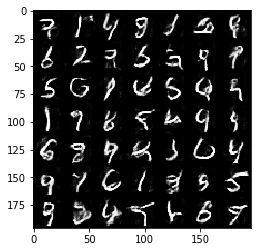

Epoch 2/2... Discriminator Loss: 1.3080... Generator Loss: 0.8705
Epoch 2/2... Discriminator Loss: 1.3261... Generator Loss: 0.8394
Epoch 2/2... Discriminator Loss: 1.4140... Generator Loss: 0.8232
Epoch 2/2... Discriminator Loss: 1.3517... Generator Loss: 0.8392
Epoch 2/2... Discriminator Loss: 1.3942... Generator Loss: 0.7864
Epoch 2/2... Discriminator Loss: 1.2537... Generator Loss: 0.8839
Epoch 2/2... Discriminator Loss: 1.4075... Generator Loss: 0.7780
Epoch 2/2... Discriminator Loss: 1.3813... Generator Loss: 0.8189
Epoch 2/2... Discriminator Loss: 1.3094... Generator Loss: 0.8515
Epoch 2/2... Discriminator Loss: 1.3046... Generator Loss: 0.8062


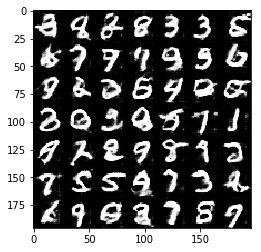

Epoch 2/2... Discriminator Loss: 1.3246... Generator Loss: 0.8395
Epoch 2/2... Discriminator Loss: 1.2754... Generator Loss: 0.8669
Epoch 2/2... Discriminator Loss: 1.3945... Generator Loss: 0.7703
Epoch 2/2... Discriminator Loss: 1.3232... Generator Loss: 0.8686
Epoch 2/2... Discriminator Loss: 1.3799... Generator Loss: 0.8388
Epoch 2/2... Discriminator Loss: 1.3563... Generator Loss: 0.7916
Epoch 2/2... Discriminator Loss: 1.3236... Generator Loss: 0.8324


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.7625... Generator Loss: 0.3073
Epoch 1/1... Discriminator Loss: 1.9764... Generator Loss: 0.2832
Epoch 1/1... Discriminator Loss: 1.5786... Generator Loss: 0.4927
Epoch 1/1... Discriminator Loss: 1.5185... Generator Loss: 0.5114
Epoch 1/1... Discriminator Loss: 1.6179... Generator Loss: 0.4739
Epoch 1/1... Discriminator Loss: 1.5866... Generator Loss: 0.5625
Epoch 1/1... Discriminator Loss: 1.2014... Generator Loss: 0.7975
Epoch 1/1... Discriminator Loss: 1.3040... Generator Loss: 0.8756
Epoch 1/1... Discriminator Loss: 1.6218... Generator Loss: 0.6186
Epoch 1/1... Discriminator Loss: 1.6068... Generator Loss: 0.6583


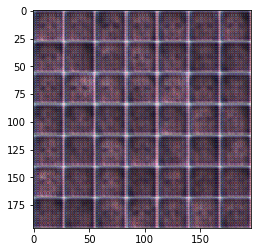

Epoch 1/1... Discriminator Loss: 1.8057... Generator Loss: 0.5157
Epoch 1/1... Discriminator Loss: 1.9958... Generator Loss: 0.4191
Epoch 1/1... Discriminator Loss: 1.6577... Generator Loss: 0.6891
Epoch 1/1... Discriminator Loss: 1.2869... Generator Loss: 0.8475
Epoch 1/1... Discriminator Loss: 1.4177... Generator Loss: 0.7252
Epoch 1/1... Discriminator Loss: 1.5011... Generator Loss: 0.7286
Epoch 1/1... Discriminator Loss: 1.5235... Generator Loss: 0.5852
Epoch 1/1... Discriminator Loss: 1.5993... Generator Loss: 0.6741
Epoch 1/1... Discriminator Loss: 1.6825... Generator Loss: 0.6687
Epoch 1/1... Discriminator Loss: 1.4092... Generator Loss: 0.7551


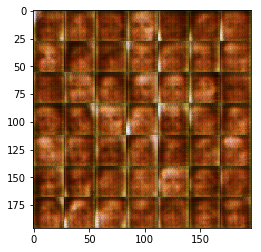

Epoch 1/1... Discriminator Loss: 1.4227... Generator Loss: 0.7921
Epoch 1/1... Discriminator Loss: 1.6180... Generator Loss: 0.6797
Epoch 1/1... Discriminator Loss: 1.3793... Generator Loss: 0.7843
Epoch 1/1... Discriminator Loss: 1.5008... Generator Loss: 0.6362
Epoch 1/1... Discriminator Loss: 1.5098... Generator Loss: 0.7108
Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 0.7859
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.7592
Epoch 1/1... Discriminator Loss: 1.3575... Generator Loss: 0.8050
Epoch 1/1... Discriminator Loss: 1.4781... Generator Loss: 0.6826
Epoch 1/1... Discriminator Loss: 1.4232... Generator Loss: 0.7231


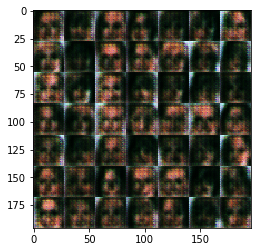

Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 0.7613
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.7435
Epoch 1/1... Discriminator Loss: 1.4383... Generator Loss: 0.7676
Epoch 1/1... Discriminator Loss: 1.4436... Generator Loss: 0.7814
Epoch 1/1... Discriminator Loss: 1.4687... Generator Loss: 0.7579
Epoch 1/1... Discriminator Loss: 1.4726... Generator Loss: 0.7694
Epoch 1/1... Discriminator Loss: 1.4736... Generator Loss: 0.7460
Epoch 1/1... Discriminator Loss: 1.3944... Generator Loss: 0.7422
Epoch 1/1... Discriminator Loss: 1.4742... Generator Loss: 0.7003
Epoch 1/1... Discriminator Loss: 1.5001... Generator Loss: 0.7477


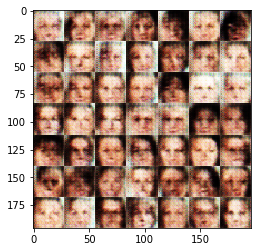

Epoch 1/1... Discriminator Loss: 1.4025... Generator Loss: 0.7112
Epoch 1/1... Discriminator Loss: 1.4773... Generator Loss: 0.7257
Epoch 1/1... Discriminator Loss: 1.3642... Generator Loss: 0.7870
Epoch 1/1... Discriminator Loss: 1.4360... Generator Loss: 0.7452
Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 0.7915
Epoch 1/1... Discriminator Loss: 1.4277... Generator Loss: 0.7601
Epoch 1/1... Discriminator Loss: 1.4296... Generator Loss: 0.7265
Epoch 1/1... Discriminator Loss: 1.5494... Generator Loss: 0.6726
Epoch 1/1... Discriminator Loss: 1.4541... Generator Loss: 0.7849
Epoch 1/1... Discriminator Loss: 1.4963... Generator Loss: 0.6913


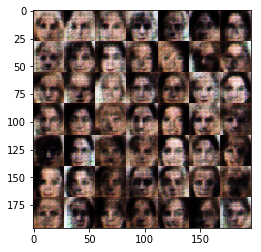

Epoch 1/1... Discriminator Loss: 1.3335... Generator Loss: 0.8577
Epoch 1/1... Discriminator Loss: 1.5208... Generator Loss: 0.6990
Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.8576
Epoch 1/1... Discriminator Loss: 1.4628... Generator Loss: 0.7144
Epoch 1/1... Discriminator Loss: 1.4509... Generator Loss: 0.8572
Epoch 1/1... Discriminator Loss: 1.4057... Generator Loss: 0.7499
Epoch 1/1... Discriminator Loss: 1.4930... Generator Loss: 0.7011
Epoch 1/1... Discriminator Loss: 1.4095... Generator Loss: 0.8088
Epoch 1/1... Discriminator Loss: 1.4543... Generator Loss: 0.7470
Epoch 1/1... Discriminator Loss: 1.4618... Generator Loss: 0.8518


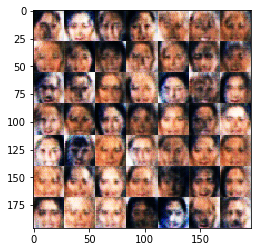

Epoch 1/1... Discriminator Loss: 1.4039... Generator Loss: 0.7668
Epoch 1/1... Discriminator Loss: 1.4755... Generator Loss: 0.5968
Epoch 1/1... Discriminator Loss: 1.4714... Generator Loss: 0.8352
Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.6859
Epoch 1/1... Discriminator Loss: 1.4712... Generator Loss: 0.7177
Epoch 1/1... Discriminator Loss: 1.4383... Generator Loss: 0.7684
Epoch 1/1... Discriminator Loss: 1.4405... Generator Loss: 0.7463
Epoch 1/1... Discriminator Loss: 1.4443... Generator Loss: 0.7613
Epoch 1/1... Discriminator Loss: 1.3445... Generator Loss: 0.7712
Epoch 1/1... Discriminator Loss: 1.5138... Generator Loss: 0.7467


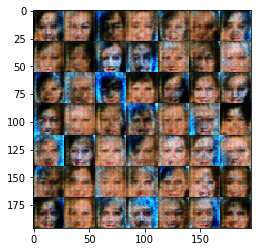

Epoch 1/1... Discriminator Loss: 1.5383... Generator Loss: 0.8621
Epoch 1/1... Discriminator Loss: 1.3337... Generator Loss: 0.7442
Epoch 1/1... Discriminator Loss: 1.4332... Generator Loss: 0.8125
Epoch 1/1... Discriminator Loss: 1.4022... Generator Loss: 0.7449
Epoch 1/1... Discriminator Loss: 1.4887... Generator Loss: 0.7283
Epoch 1/1... Discriminator Loss: 1.4293... Generator Loss: 0.7791
Epoch 1/1... Discriminator Loss: 1.2989... Generator Loss: 0.7393
Epoch 1/1... Discriminator Loss: 1.4837... Generator Loss: 0.7211
Epoch 1/1... Discriminator Loss: 1.4450... Generator Loss: 0.8210
Epoch 1/1... Discriminator Loss: 1.4551... Generator Loss: 0.6830


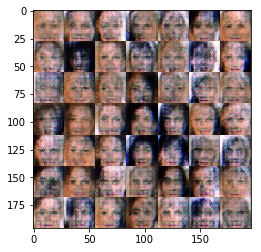

Epoch 1/1... Discriminator Loss: 1.4421... Generator Loss: 0.7924
Epoch 1/1... Discriminator Loss: 1.4267... Generator Loss: 0.7214
Epoch 1/1... Discriminator Loss: 1.4203... Generator Loss: 0.7520
Epoch 1/1... Discriminator Loss: 1.4146... Generator Loss: 0.7811
Epoch 1/1... Discriminator Loss: 1.4162... Generator Loss: 0.7939
Epoch 1/1... Discriminator Loss: 1.4269... Generator Loss: 0.7321
Epoch 1/1... Discriminator Loss: 1.4411... Generator Loss: 0.7550
Epoch 1/1... Discriminator Loss: 1.3770... Generator Loss: 0.7840
Epoch 1/1... Discriminator Loss: 1.3383... Generator Loss: 0.7809
Epoch 1/1... Discriminator Loss: 1.4045... Generator Loss: 0.7919


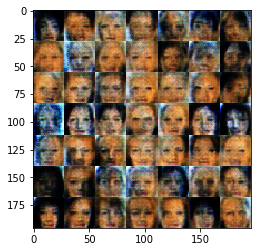

Epoch 1/1... Discriminator Loss: 1.4213... Generator Loss: 0.9561
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.7052
Epoch 1/1... Discriminator Loss: 1.4208... Generator Loss: 0.8140
Epoch 1/1... Discriminator Loss: 1.4043... Generator Loss: 0.8453
Epoch 1/1... Discriminator Loss: 1.4284... Generator Loss: 0.7280
Epoch 1/1... Discriminator Loss: 1.4471... Generator Loss: 0.7582
Epoch 1/1... Discriminator Loss: 1.3614... Generator Loss: 0.7215
Epoch 1/1... Discriminator Loss: 1.3478... Generator Loss: 0.7491
Epoch 1/1... Discriminator Loss: 1.4698... Generator Loss: 0.7777
Epoch 1/1... Discriminator Loss: 1.5732... Generator Loss: 0.6253


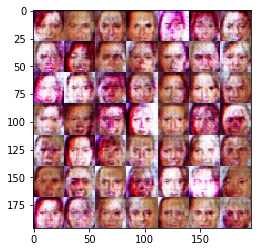

Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 0.7334
Epoch 1/1... Discriminator Loss: 1.4447... Generator Loss: 0.7713
Epoch 1/1... Discriminator Loss: 1.4438... Generator Loss: 0.7857
Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.8174
Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 0.7591
Epoch 1/1... Discriminator Loss: 1.4424... Generator Loss: 0.7871
Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.7678
Epoch 1/1... Discriminator Loss: 1.3793... Generator Loss: 0.7456
Epoch 1/1... Discriminator Loss: 1.4436... Generator Loss: 0.6827
Epoch 1/1... Discriminator Loss: 1.4484... Generator Loss: 0.7965


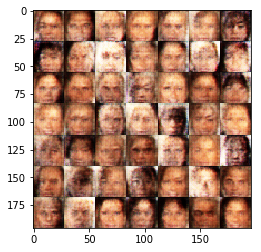

Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 0.7682
Epoch 1/1... Discriminator Loss: 1.3720... Generator Loss: 0.8441
Epoch 1/1... Discriminator Loss: 1.4595... Generator Loss: 0.7371
Epoch 1/1... Discriminator Loss: 1.4483... Generator Loss: 0.8036
Epoch 1/1... Discriminator Loss: 1.3716... Generator Loss: 0.8127
Epoch 1/1... Discriminator Loss: 1.3897... Generator Loss: 0.8123
Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 0.7703
Epoch 1/1... Discriminator Loss: 1.3635... Generator Loss: 0.7161
Epoch 1/1... Discriminator Loss: 1.4379... Generator Loss: 0.7396
Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 0.7727


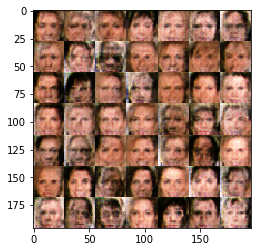

Epoch 1/1... Discriminator Loss: 1.4030... Generator Loss: 0.7599
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.8132
Epoch 1/1... Discriminator Loss: 1.3700... Generator Loss: 0.8001
Epoch 1/1... Discriminator Loss: 1.4072... Generator Loss: 0.7333
Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 0.7985
Epoch 1/1... Discriminator Loss: 1.3685... Generator Loss: 0.7818
Epoch 1/1... Discriminator Loss: 1.3969... Generator Loss: 0.7885
Epoch 1/1... Discriminator Loss: 1.3980... Generator Loss: 0.7673
Epoch 1/1... Discriminator Loss: 1.4302... Generator Loss: 0.7693
Epoch 1/1... Discriminator Loss: 1.3577... Generator Loss: 0.7977


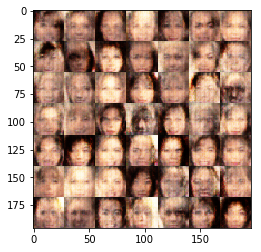

Epoch 1/1... Discriminator Loss: 1.4285... Generator Loss: 0.7221
Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.7490
Epoch 1/1... Discriminator Loss: 1.3661... Generator Loss: 0.8234
Epoch 1/1... Discriminator Loss: 1.4177... Generator Loss: 0.8180
Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.8309
Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 0.7635
Epoch 1/1... Discriminator Loss: 1.3737... Generator Loss: 0.7693
Epoch 1/1... Discriminator Loss: 1.4003... Generator Loss: 0.8232
Epoch 1/1... Discriminator Loss: 1.3558... Generator Loss: 0.7867
Epoch 1/1... Discriminator Loss: 1.3637... Generator Loss: 0.6979


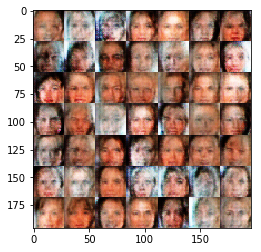

Epoch 1/1... Discriminator Loss: 1.4232... Generator Loss: 0.7436
Epoch 1/1... Discriminator Loss: 1.3730... Generator Loss: 0.7431
Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.8040
Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.7967
Epoch 1/1... Discriminator Loss: 1.3787... Generator Loss: 0.7870
Epoch 1/1... Discriminator Loss: 1.4982... Generator Loss: 0.6387
Epoch 1/1... Discriminator Loss: 1.4082... Generator Loss: 0.8223
Epoch 1/1... Discriminator Loss: 1.4663... Generator Loss: 0.6911
Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 0.8010
Epoch 1/1... Discriminator Loss: 1.4223... Generator Loss: 0.7234


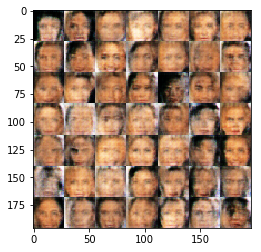

Epoch 1/1... Discriminator Loss: 1.3992... Generator Loss: 0.8173
Epoch 1/1... Discriminator Loss: 1.3570... Generator Loss: 0.8599
Epoch 1/1... Discriminator Loss: 1.3020... Generator Loss: 0.7842
Epoch 1/1... Discriminator Loss: 1.4369... Generator Loss: 0.8385
Epoch 1/1... Discriminator Loss: 1.4694... Generator Loss: 0.7658
Epoch 1/1... Discriminator Loss: 1.3848... Generator Loss: 0.7788
Epoch 1/1... Discriminator Loss: 1.4112... Generator Loss: 0.7193
Epoch 1/1... Discriminator Loss: 1.4356... Generator Loss: 0.8063
Epoch 1/1... Discriminator Loss: 1.4384... Generator Loss: 0.7499
Epoch 1/1... Discriminator Loss: 1.3915... Generator Loss: 0.7967


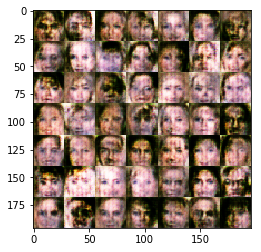

Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 0.8110
Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 0.8190
Epoch 1/1... Discriminator Loss: 1.3826... Generator Loss: 0.7492
Epoch 1/1... Discriminator Loss: 1.3788... Generator Loss: 0.8737
Epoch 1/1... Discriminator Loss: 1.3857... Generator Loss: 0.7470
Epoch 1/1... Discriminator Loss: 1.3817... Generator Loss: 0.8418
Epoch 1/1... Discriminator Loss: 1.3690... Generator Loss: 0.7900
Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 0.7394
Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 0.7626
Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.8389


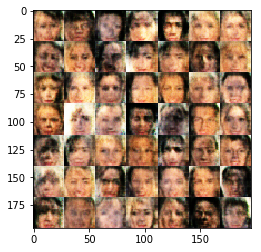

Epoch 1/1... Discriminator Loss: 1.3634... Generator Loss: 0.8148
Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.7377
Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.8273
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.7692
Epoch 1/1... Discriminator Loss: 1.3852... Generator Loss: 0.7324
Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.8018
Epoch 1/1... Discriminator Loss: 1.3941... Generator Loss: 0.7992
Epoch 1/1... Discriminator Loss: 1.4074... Generator Loss: 0.8050
Epoch 1/1... Discriminator Loss: 1.3769... Generator Loss: 0.7909
Epoch 1/1... Discriminator Loss: 1.3873... Generator Loss: 0.7778


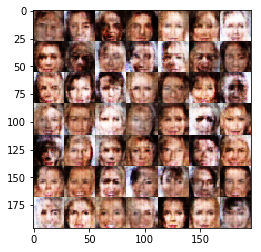

Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.7764
Epoch 1/1... Discriminator Loss: 1.3710... Generator Loss: 0.8054
Epoch 1/1... Discriminator Loss: 1.3759... Generator Loss: 0.7741
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.7935
Epoch 1/1... Discriminator Loss: 1.4059... Generator Loss: 0.7631
Epoch 1/1... Discriminator Loss: 1.3805... Generator Loss: 0.7870
Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.8074
Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 0.7889
Epoch 1/1... Discriminator Loss: 1.4276... Generator Loss: 0.7712
Epoch 1/1... Discriminator Loss: 1.3546... Generator Loss: 0.7634


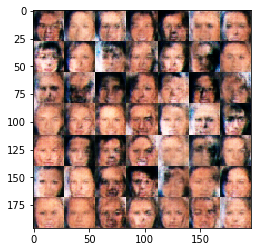

Epoch 1/1... Discriminator Loss: 1.4044... Generator Loss: 0.7898
Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.8067
Epoch 1/1... Discriminator Loss: 1.4044... Generator Loss: 0.8243
Epoch 1/1... Discriminator Loss: 1.3612... Generator Loss: 0.7645
Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 0.7683
Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.7785
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.8180
Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 0.8002
Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.7899
Epoch 1/1... Discriminator Loss: 1.4134... Generator Loss: 0.8172


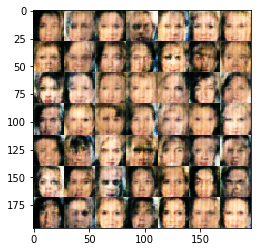

Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 0.8252
Epoch 1/1... Discriminator Loss: 1.4707... Generator Loss: 0.6865
Epoch 1/1... Discriminator Loss: 1.3816... Generator Loss: 0.8115
Epoch 1/1... Discriminator Loss: 1.3852... Generator Loss: 0.7295
Epoch 1/1... Discriminator Loss: 1.3838... Generator Loss: 0.8558
Epoch 1/1... Discriminator Loss: 1.3723... Generator Loss: 0.7880
Epoch 1/1... Discriminator Loss: 1.3762... Generator Loss: 0.8297
Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.7782
Epoch 1/1... Discriminator Loss: 1.4178... Generator Loss: 0.7788
Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 0.7796


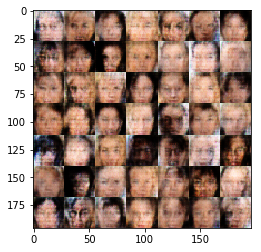

Epoch 1/1... Discriminator Loss: 1.3792... Generator Loss: 0.7814
Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.8485
Epoch 1/1... Discriminator Loss: 1.4126... Generator Loss: 0.7687
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.8355
Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.8049
Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 0.7959
Epoch 1/1... Discriminator Loss: 1.3814... Generator Loss: 0.7888
Epoch 1/1... Discriminator Loss: 1.3825... Generator Loss: 0.7738
Epoch 1/1... Discriminator Loss: 1.3833... Generator Loss: 0.7948
Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.7930


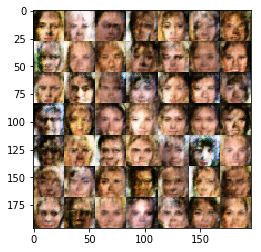

Epoch 1/1... Discriminator Loss: 1.3676... Generator Loss: 0.7789
Epoch 1/1... Discriminator Loss: 1.3787... Generator Loss: 0.8395
Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 0.7623
Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.8186
Epoch 1/1... Discriminator Loss: 1.3860... Generator Loss: 0.7711
Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.7939
Epoch 1/1... Discriminator Loss: 1.3661... Generator Loss: 0.8102
Epoch 1/1... Discriminator Loss: 1.3639... Generator Loss: 0.8045
Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 0.7791
Epoch 1/1... Discriminator Loss: 1.3795... Generator Loss: 0.7951


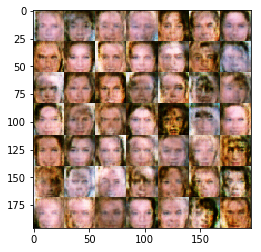

Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 0.8207
Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 0.8112
Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.7625
Epoch 1/1... Discriminator Loss: 1.3706... Generator Loss: 0.8357
Epoch 1/1... Discriminator Loss: 1.3648... Generator Loss: 0.7976
Epoch 1/1... Discriminator Loss: 1.4233... Generator Loss: 0.7983
Epoch 1/1... Discriminator Loss: 1.4004... Generator Loss: 0.7449
Epoch 1/1... Discriminator Loss: 1.3497... Generator Loss: 0.8232
Epoch 1/1... Discriminator Loss: 1.4074... Generator Loss: 0.7453
Epoch 1/1... Discriminator Loss: 1.3475... Generator Loss: 0.7779


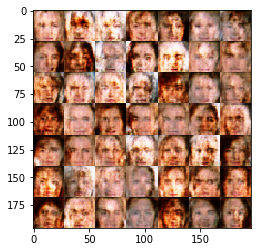

Epoch 1/1... Discriminator Loss: 1.4419... Generator Loss: 0.7413
Epoch 1/1... Discriminator Loss: 1.4343... Generator Loss: 0.8072
Epoch 1/1... Discriminator Loss: 1.3459... Generator Loss: 0.8386
Epoch 1/1... Discriminator Loss: 1.3990... Generator Loss: 0.8101
Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.7842
Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.7818
Epoch 1/1... Discriminator Loss: 1.3967... Generator Loss: 0.7313
Epoch 1/1... Discriminator Loss: 1.3618... Generator Loss: 0.7961
Epoch 1/1... Discriminator Loss: 1.3922... Generator Loss: 0.8154
Epoch 1/1... Discriminator Loss: 1.3889... Generator Loss: 0.8567


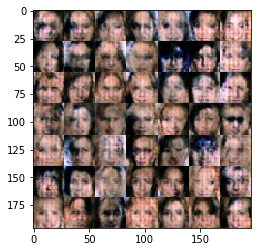

Epoch 1/1... Discriminator Loss: 1.3575... Generator Loss: 0.7681
Epoch 1/1... Discriminator Loss: 1.3924... Generator Loss: 0.7433
Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 0.8438
Epoch 1/1... Discriminator Loss: 1.4150... Generator Loss: 0.7845
Epoch 1/1... Discriminator Loss: 1.3841... Generator Loss: 0.7872
Epoch 1/1... Discriminator Loss: 1.3681... Generator Loss: 0.7831
Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.7747
Epoch 1/1... Discriminator Loss: 1.3916... Generator Loss: 0.7894
Epoch 1/1... Discriminator Loss: 1.3769... Generator Loss: 0.7855
Epoch 1/1... Discriminator Loss: 1.3902... Generator Loss: 0.7928


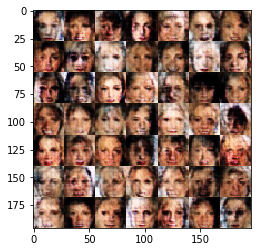

Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.7907
Epoch 1/1... Discriminator Loss: 1.3705... Generator Loss: 0.7912
Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 0.7820
Epoch 1/1... Discriminator Loss: 1.3718... Generator Loss: 0.8095
Epoch 1/1... Discriminator Loss: 1.3774... Generator Loss: 0.7944
Epoch 1/1... Discriminator Loss: 1.3599... Generator Loss: 0.7831
Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.7991
Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.8586
Epoch 1/1... Discriminator Loss: 1.3647... Generator Loss: 0.7973
Epoch 1/1... Discriminator Loss: 1.3538... Generator Loss: 0.7757


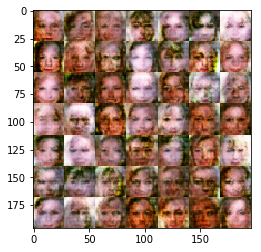

Epoch 1/1... Discriminator Loss: 1.3756... Generator Loss: 0.8248
Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.7925
Epoch 1/1... Discriminator Loss: 1.4308... Generator Loss: 0.8055
Epoch 1/1... Discriminator Loss: 1.3629... Generator Loss: 0.8341
Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 0.7650
Epoch 1/1... Discriminator Loss: 1.4111... Generator Loss: 0.8243
Epoch 1/1... Discriminator Loss: 1.3698... Generator Loss: 0.7889
Epoch 1/1... Discriminator Loss: 1.3953... Generator Loss: 0.8106
Epoch 1/1... Discriminator Loss: 1.3836... Generator Loss: 0.7197
Epoch 1/1... Discriminator Loss: 1.3628... Generator Loss: 0.8020


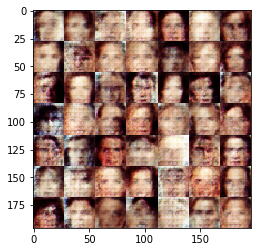

Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 0.7330
Epoch 1/1... Discriminator Loss: 1.3894... Generator Loss: 0.8016
Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.8687
Epoch 1/1... Discriminator Loss: 1.3443... Generator Loss: 0.7516
Epoch 1/1... Discriminator Loss: 1.3943... Generator Loss: 0.7614
Epoch 1/1... Discriminator Loss: 1.3421... Generator Loss: 0.8313
Epoch 1/1... Discriminator Loss: 1.3711... Generator Loss: 0.7769
Epoch 1/1... Discriminator Loss: 1.3749... Generator Loss: 0.7809
Epoch 1/1... Discriminator Loss: 1.3793... Generator Loss: 0.8105
Epoch 1/1... Discriminator Loss: 1.4618... Generator Loss: 0.7919


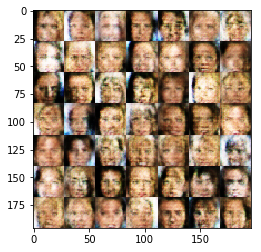

Epoch 1/1... Discriminator Loss: 1.4096... Generator Loss: 0.7780
Epoch 1/1... Discriminator Loss: 1.4234... Generator Loss: 0.7302
Epoch 1/1... Discriminator Loss: 1.4155... Generator Loss: 0.7072
Epoch 1/1... Discriminator Loss: 1.4381... Generator Loss: 0.7813
Epoch 1/1... Discriminator Loss: 1.4201... Generator Loss: 0.7736
Epoch 1/1... Discriminator Loss: 1.4132... Generator Loss: 0.7675
Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.8182
Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 0.8091
Epoch 1/1... Discriminator Loss: 1.4024... Generator Loss: 0.8323
Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.7393


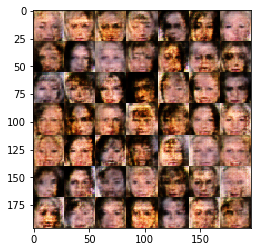

Epoch 1/1... Discriminator Loss: 1.4018... Generator Loss: 0.8295
Epoch 1/1... Discriminator Loss: 1.3754... Generator Loss: 0.7967
Epoch 1/1... Discriminator Loss: 1.4084... Generator Loss: 0.7210
Epoch 1/1... Discriminator Loss: 1.3746... Generator Loss: 0.8483
Epoch 1/1... Discriminator Loss: 1.3522... Generator Loss: 0.8230
Epoch 1/1... Discriminator Loss: 1.4196... Generator Loss: 0.7626
Epoch 1/1... Discriminator Loss: 1.3718... Generator Loss: 0.7366
Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 0.8500
Epoch 1/1... Discriminator Loss: 1.3379... Generator Loss: 0.7782
Epoch 1/1... Discriminator Loss: 1.3691... Generator Loss: 0.9114


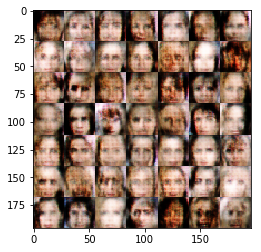

Epoch 1/1... Discriminator Loss: 1.4087... Generator Loss: 0.7258
Epoch 1/1... Discriminator Loss: 1.3559... Generator Loss: 0.7959
Epoch 1/1... Discriminator Loss: 1.3902... Generator Loss: 0.7713
Epoch 1/1... Discriminator Loss: 1.3919... Generator Loss: 0.8687
Epoch 1/1... Discriminator Loss: 1.3996... Generator Loss: 0.7587
Epoch 1/1... Discriminator Loss: 1.3797... Generator Loss: 0.7734


In [13]:
batch_size = 64
z_dim = 100
learning_rate = .0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.